# GeoPick: Centroid and uncertainty calculation
November 2023

---
This Notebook illustrates how __GeoPick__ v1.0.3 applies the point-radius method [[1]](#w2004)
to calculate the centroid (Darwin Core's [decimalLatitude](http://rs.tdwg.org/dwc/terms/decimalLatitude) and [decimalLongitude](http://rs.tdwg.org/dwc/terms/decimalLongitude)) and uncertainty (Darwin Core's [coordinateUncertaintyInMeters](http://rs.tdwg.org/dwc/terms/coordinateUncertaintyInMeters)) associated with a georeferenced locality description (Darwin Core's [verbatimLocality](http://rs.tdwg.org/dwc/terms/verbatimLocality)) by approximating the smallest enclosing circle of a geometry. The example given below is for a polygon with a corrected center [[2](#cw2020), [3](#z2020)]. For line, polyline and multipolygon geometries the calculation is analogous. GeoPick follows steps 1 to 6 to deliver the final results. The case in which the centroid falls on top of the geometry when calculating its smallest enclosing circle would be a simplified version of the process here described, i.e. step 5 below would not be needed. 

In [23]:
import geopandas as gpd
import pandas as pd
import pyproj
import shapely
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import geopick as gp
import ipywidgets as widgets
from IPython.display import display
import sys
import math
import folium
import warnings

warnings.filterwarnings('ignore')
random_seed = 42

## 1 - Specimen's locality interpretation
The polygon below represents the geometry resulting from retrospective georeferencing, the process by which the textual description of a locality where a specimen was collected is interpreted over a map. This locality description (Darwin Core's [verbatimLocality](http://rs.tdwg.org/dwc/terms/verbatimLocality)) was available on a specimen's associated metadata, i.e. tag, field notebook, etc. The geometry can be directly digitized with __GeoPick__, imported as [Well-Known Text (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), or captured from a search to the OpenStreetMap data [Nominatim service](https://nominatim.openstreetmap.org/ui/search.html). The example below corresponds to a locality description of the collection site of a plant in the Cap de Creus area, in northeastern Catalonia, Spain.

#### Run next cell and enter your WKT in the text area below, alternatiely use the one by default

In [24]:
# Create a Textarea widget
textarea_input = widgets.Textarea(
    value='',
    placeholder='Paste your text here',
    # description='WKT:',
    disabled=False,
    layout={'width': '800px', 'height': '300px'}  # Set width and height
)
def clear_wkt_textarea(b):
    # Clear the Textarea by setting its value to an empty string    
    textarea_input.value = ""

button = widgets.Button(description="Clear WKT")
button.on_click(clear_wkt_textarea)
box = widgets.VBox([button, textarea_input], layout=widgets.Layout(align_items='flex-start'))

# f_wkt = "../data/capdecreus.txt"
f_wkt = "../data/capdecreus.wkt"
location_wkt = textarea_input.value
location_wkt = pathlib.Path(f_wkt).read_text()
textarea_input.value = location_wkt
display(box)


#### Import location (WKT)

In [39]:
def extract_wkt(items):  
  wkt = None
  for item in items:
    if item.startswith("POINT") or item.startswith("LINESTRING") or \
      item.startswith("MULTILINESTRING") or item.startswith("POLYGON") or \
      item.startswith("MULTIPOLYGON"):
        wkt = item
        break  # Stop searching once a match is found
  return wkt
items = textarea_input.value.split("\t")
location_wkt = extract_wkt(items)

if location_wkt.startswith("POINT"):
  if(len(items) == 1):
    print("POINT geometry, uncertainty not specified.\n")
  else:
    print("POINT geometry.\n")
    print("Latitude:", items[0], ", Longitude:", items[1], ", Uncertainty:", items[3])
  class StopExecution(Exception):
   def _render_traceback_(self):
    return []
  raise StopExecution

location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
location_wgs84.crs = "EPSG:4326"

#### Location

In [40]:
# Map
latitude = location_wgs84.centroid.get_coordinates()["y"][0]
longitude = location_wgs84.centroid.get_coordinates()["x"][0]
fcol = lambda x: {
    'fillColor': "blue" if x["properties"]["is_marine"] == "True" else "green",
    'color': "blue" if x["properties"]["is_marine"] == "True" else "green"
}

m = folium.Map(location = [latitude, longitude], zoom_start = 15)
folium.GeoJson(location_wgs84).add_to(m)
m

## 2 - Azimuth Equal-Area projection centered on the locality
In order to correctly calculate the smallest enclosing circle, __GeoPick__ needs to work with an equidistant projection which does not distort distances. GeoPick uses the [Azimuthal Equal Area (AEQD) projection](https://proj.org/en/9.3/operations/projections/aeqd.html) for which all points on the map are at proportionally correct distances from the center. Thus, __GeoPick__ first reprojects the georeferenced geometry from [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) to [AEQD](https://proj.org/en/9.3/operations/projections/aeqd.html), using the centroid corresponding to the locality in [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) as an approximation to the center on which to focus the [AEQD](https://proj.org/en/9.3/operations/projections/aeqd.html) projection.

#### Project location to parameterized AEQD and calculate centroid

In [27]:
# Get projection focused on WGS84 centroid
centroid_wgs84 = location_wgs84.centroid
proj_aeqd = gp.get_proj_aeqd(centroid_wgs84)

# Project location to AEQD
location_aeqd = location_wgs84.to_crs(proj_aeqd)
centroid_aeqd = centroid_wgs84.to_crs(proj_aeqd)

For the given example, the parameterized projection is “+proj=aeqd +lat_0=42.25042730113184 +lon_0=3.2392134652826163 +x_0=0 +y_0=0 +R=6371000 +units=m +no_defs +type=crs”. Below we can see the Earth projected with our site at its center (red cross).

<Axes: >

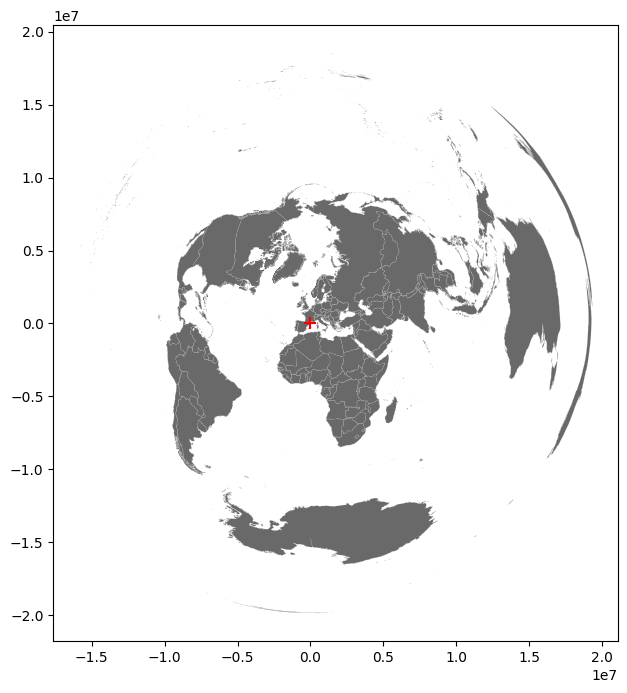

In [37]:
world_4326 = gpd.read_file("../data/CNTR_RG_01M_2020_4326.geojson")
world_aeqd = world_4326.to_crs(proj_aeqd)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
world_aeqd.plot(aspect = "equal", facecolor = "dimgrey", edgecolor = "silver", linewidth = 0.1, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "red", marker = "+", markersize = 75, ax = ax)

## 3 - Eventual geometry simplification

If the number of vertices in the geometry is too large, GeoPick simplifies it for performance reasons. Currently, GeoPick sets the maximum number of vertices to 10 000. For geometries above this threshold, a maximum tolerance of 500m between vertices is applied.

In [ ]:
max_points_polygon =10000
tolerance = 500
location_aeqd = gp.simplify_geometry(location_aeqd)

In our example, the geometry HAS NOT BEEN SIMPLIFIED since it had 252 vertices

In [41]:

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# location_wgs84.plot(ax=axes[0], color='red', edgecolor='black')
# centroid_wgs84.plot(ax=axes[0], color='blue')
# axes[0].set_title('WGS84')
# location_aeqd.plot(ax=axes[1], color='red', edgecolor='black')
# centroid_aeqd.plot(ax=axes[1], color='blue')
# axes[1].set_title('AEQD')
# xticks = axes[1].get_xticklabels()
# axes[1].set_xticklabels(xticks, rotation=45); # ; makes xticks not to be printed

## 4 -Calculate SEC and its centroid

With the site projected in AEQD, GeoPick calculates the smallest enclosing circle with its corresponding centroid and radius of uncertainty. GeoPick uses the st_minimum_bounding_circle function of the R package lwgeom [4], which in turn uses the liblwgeom light-weight geometry library of PostGIS, to approximate the smallest enclosing circle.

Text(0, 0, '290m')

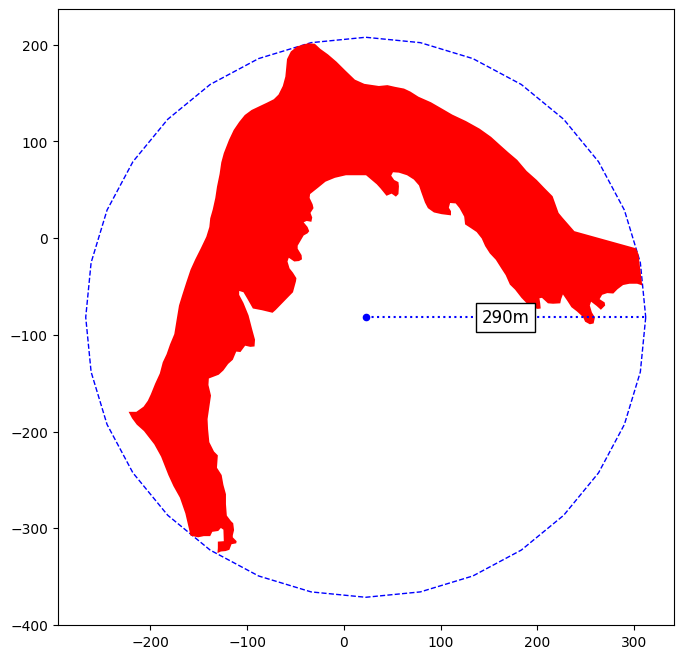

In [114]:
sec_aeqd = gp.get_sec(location_aeqd)
centroid_aeqd = gp.get_sec_centroid(sec_aeqd)
centroid_aeqd.crs = proj_aeqd
coords1 = centroid_aeqd.get_coordinates()
p1 = [coords1["x"][0], coords1["y"][0]]
coords2 = sec_aeqd.get_coordinates().iloc[0]
p2 = [max(sec_aeqd.get_coordinates()["x"]), coords2["y"]]
uncertainty = str(round((max(sec_aeqd.get_coordinates()["x"]) - coords1["x"])[0])) + "m"
radius_line = gpd.GeoSeries(
    [
        shapely.geometry.LineString([(p1[0], p1[1]), (p2[0], p2[1])]),
    ],
    crs=proj_aeqd
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
sec_aeqd.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
radius_line.plot(aspect = "equal", color = "blue", markersize = 20, linestyle = "dotted", ax = ax)
ax.annotate(uncertainty, xy=(radius_line.centroid.x[0], radius_line.centroid.y[0]), xytext=(0, 0), textcoords='offset points', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=1, edgecolor='black'))


## 5 - Correct center if necessary

When the centroid falls outside the geometry, as is the case in our example above, GeoPick calculates the corrected center instead [2, 3]. If the centroid had fallen on top of the geometry, GeoPick would skip this step and go directly to step 6.

In [118]:
centroid_inside = gp.is_centroid_inside(centroid_aeqd, location_aeqd)

False

To correct the center, GeoPick follows the substeps 5.1 to 5.3:

### 5.1 - Candidates to become the new corrected center

When calculating the corrected center, GeoPick gathers a list of candidate points by selecting the vertices of the geometry (5.1.1 black dots). For performance reasons, GeoPick restricts this list of candidate points to a sample of 50 (5.1.1 yellow dots) in the case the number of vertices was greater than that. Then, it finds the nearest point on the geometry’s perimeter (5.1.2 green dot) to the centroid that fell outside (5.1.2 blue cross), which may not correspond to an existing geometry vertex, and adds it to the final candidate list (5.1.3 yellow dots).

#### 5.1.1 - Sample of geometry vertices (black dots) as candidate points (yellow dots).

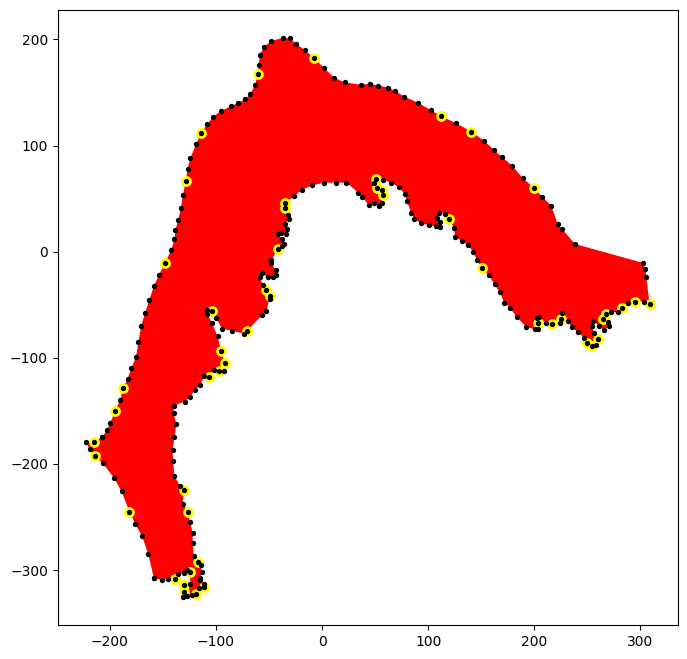

In [135]:
if not centroid_inside:
  # Get all vertices
  vertices = gp.get_all_vertices(location_aeqd)
  # Get candidate vertices
  candidates = gp.get_candidate_vertices(vertices)

  # Plot
  fig, ax = plt.subplots(figsize=(8, 8))
  location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
  candidates.plot(aspect = "equal", color = "yellow", markersize = 45, ax = ax)
  vertices.plot(aspect = "equal", color = "black", markersize = 8, ax = ax)

#### 5.1.2 - Nearest point (green dot) to the centroid (blue cross).

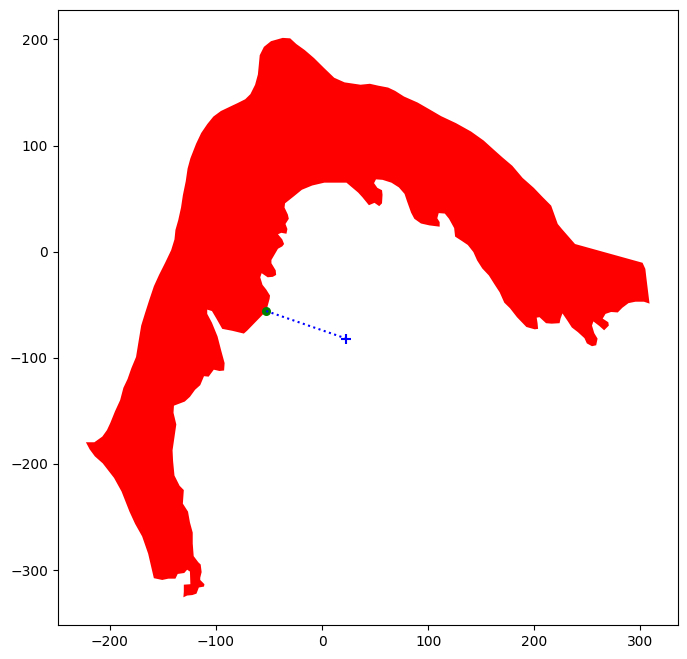

In [158]:
if not centroid_inside:
  np = gp.get_nearest_point(centroid_aeqd, location_aeqd, proj_aeqd)

  # Plot
  coords_np = np.get_coordinates()
  coords_centroid_aeqd = centroid_aeqd.get_coordinates()
  radius_line = gpd.GeoSeries(
      [
          shapely.geometry.LineString([
            (coords_np['x'][0], coords_np['y'][0]), 
            (coords_centroid_aeqd['x'][0], coords_centroid_aeqd['y'][0])
            ]),
      ],
      crs=proj_aeqd
  )
  
  fig, ax = plt.subplots(figsize=(8, 8))
  location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
  np.plot(aspect = "equal", color = "green", facecolors = "green", markersize = 30, ax = ax)
  centroid_aeqd.plot(aspect = "equal", color = "blue", marker = "+", markersize = 50, ax = ax)
  radius_line.plot(aspect = "equal", color = "blue", markersize = 20, linestyle = "dotted", ax = ax)

#### 5.1.3 - Candidate points = geometry vertices sample + nearest point

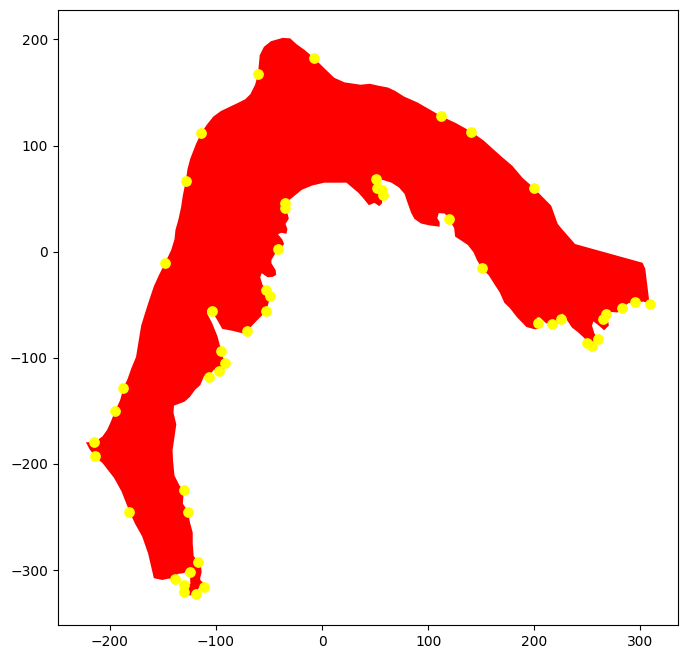

In [159]:
if not centroid_inside:
  # Add nearest point to candidate points
  candidates = pd.concat([candidates, np])
  candidates = candidates.reset_index(drop=True)

  # Plot
  fig, ax = plt.subplots(figsize=(8, 8))
  location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
  candidates.plot(aspect = "equal", color = "yellow", markersize = 45, ax = ax)


### Calculation of corrected center

To calculate the corrected center, GeoPick proceeds in two steps.

In a first approximation step it finds out which is the best candidate for the corrected center (5.2.1 green cross), i.e. which one minimizes uncertainty, among the candidate points (5.2.1 yellow dots).

Then, in a second approximation step, it explores whether it still can find out a better candidate among the nearest vertices (5.2.2 purple dots) to the point selected in the first approximation (5.2.1 green cross). These nearest vertices (5.2.2 purple dots) that are potential new candidates are drawn from the geometry vertices, which might not have been selected as candidates by the sampling process (5.1.1 black dots). GeoPick considers that within the zone where the first approximation found a candidate corrected center there might be a neighbour geometry vertex which can still improve the uncertainty.

In this example, the resulting corrected center (5.2.3 and 5.3 green cross) corresponds to the one found in the first approximation since the second approximation did not improve the uncertainty.

#### 5.2.1 - First approximation step

<Axes: >

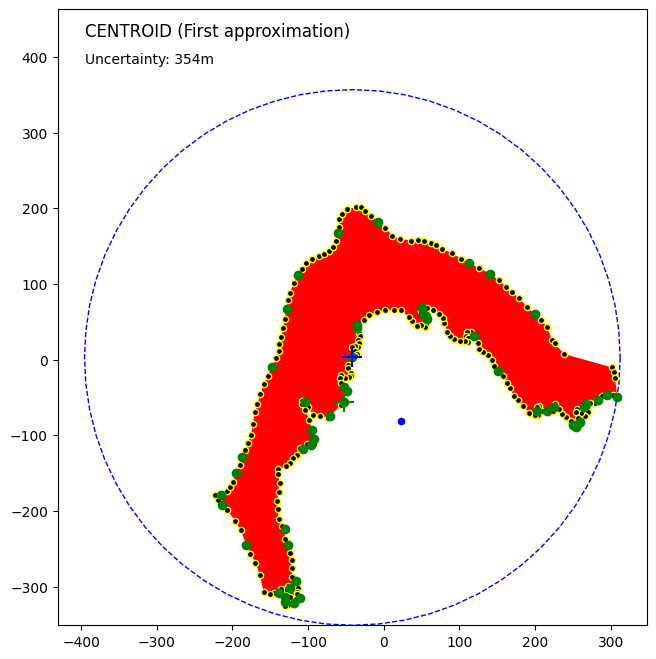

In [121]:
if not centroid_inside:
  fa = gp.get_minimum_distance_candidate(candidates, vertices)
  centroid_fa = gpd.GeoSeries(fa[0])
  centroid_fa.crs = proj_aeqd
  radius_fa = fa[1]
  sec_fa = gpd.GeoSeries(centroid_fa.buffer(radius_fa))
  sec_fa.crs = proj_aeqd

  bounds = sec_fa.bounds
  minx = bounds["minx"].iloc[0]
  maxx = bounds["maxx"].iloc[0]
  miny = bounds["miny"].iloc[0]
  maxy = bounds["maxy"].iloc[0]
  y_range = maxy - miny
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_ylim(miny, maxy + 0.15 * y_range)
  ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (First approximation)', fontsize=12, color='black')
  ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_fa:.0f}m", fontsize=10, color='black')
  sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
  location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
  vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
  centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
  np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
  candidates.plot(aspect = "equal", color = "green", ax = ax)
  centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## Second approximation


<Axes: >

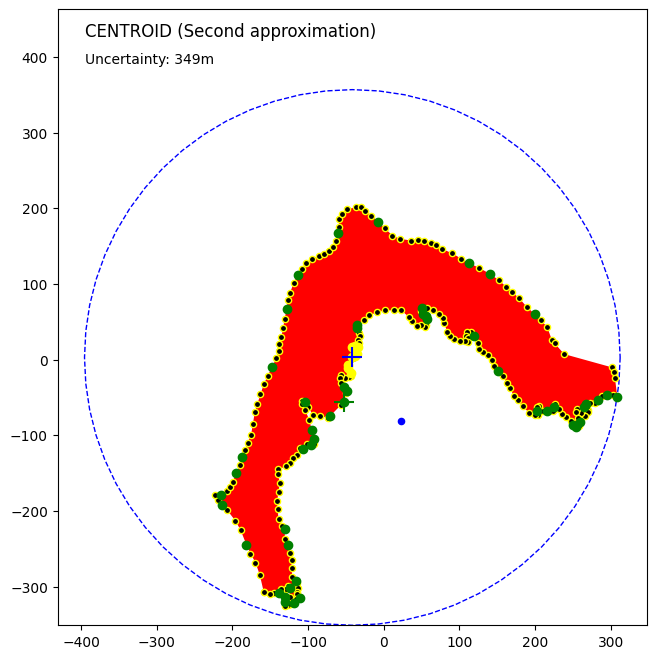

In [122]:
np_centroid_fa = gp.get_nearest_n_vertices(vertices, centroid_fa, 10)
sa = gp.get_minimum_distance_candidate(np_centroid_fa, vertices)
centroid_sa = gpd.GeoSeries(sa[0])
centroid_sa.crs = proj_aeqd
radius_sa = sa[1]
sec_sa = gpd.GeoSeries(centroid_fa.buffer(radius_sa))
sec_sa.crs = proj_aeqd


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny, maxy + 0.15 * y_range)
ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (Second approximation)', fontsize=12, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_sa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
np_centroid_fa.plot(aspect = "equal", color = "yellow", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)

## Final result

<Axes: >

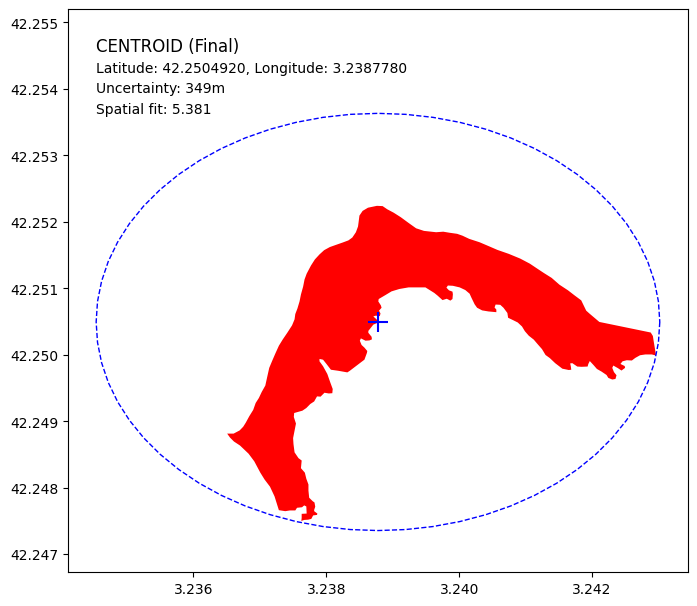

In [123]:
if(radius_sa < radius_fa):
  sec_final = sa
else:
  sec_final = fa

radius_final = sec_final[1]

# Spatial fit
if(location_aeqd.type[0].lower() == 'multipolygon' or location_aeqd.type[0].lower() == 'polygon'):
  spatial_fit = round(radius_final**2 * math.pi / location_aeqd.area[0], 3)
else:
  spatial_fit = ""

centroid_final = gpd.GeoSeries(sec_final[0])
centroid_final.crs = proj_aeqd
sec_final = gpd.GeoSeries(centroid_final.buffer(radius_final))
centroid_final = centroid_final.to_crs(4326)
sec_final = sec_final.to_crs(4326)
centroid_final_coords = centroid_final.get_coordinates()
centroid_string = f"Latitude: {centroid_final_coords['y'].iloc[0]:.7f}, \
Longitude: {centroid_final_coords['x'].iloc[0]:.7f}"

bounds = sec_final.bounds
minx = bounds["minx"].iloc[0]
maxx = bounds["maxx"].iloc[0]
miny = bounds["miny"].iloc[0]
maxy = bounds["maxy"].iloc[0]
y_range = maxy - miny

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny - 0.1 * y_range, maxy + 0.25 * y_range)
ax.text(minx, maxy + 0.15 * y_range, 'CENTROID (Final)', fontsize=12, color='black')
ax.text(minx, maxy + 0.10 * y_range, centroid_string, fontsize=10, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_final:.0f}m", fontsize=10, color='black')
ax.text(minx, maxy + 0 * y_range, f"Spatial fit: {spatial_fit:.3f}", fontsize=10, color='black')

location_wgs84.plot(aspect = "equal", color = "red", ax = ax)
sec_final.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
centroid_final.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## References
<a name="w2004">[1]</a> Wieczorek J, Guo Q, Hijmans R. (2004) The point-radius method for georeferencing locality descriptions and calculating associated uncertainty. International Journal of Geographical Information Science. 18:745--767. [https://doi.org/10.1080/13658810412331280211](https://doi.org/10.1080/13658810412331280211).
<a name="cw2020">[2]</a> Chapman AD & Wieczorek JR (2020) Georeferencing Best Practices. Copenhagen: GBIF Secretariat.
[https://doi.org/10.35035/e09p-h128](https://doi.org/10.15468/doc-gg7h-s853)  
<a name="z2020">[3]</a> Zermoglio PF, Chapman AD, Wieczorek JR, Luna MC & Bloom DA (2020) Georeferencing Quick Reference Guide. Copenhagen: GBIF Secretariat. [https://doi.org/10.35035/e09p-h128](https://doi.org/10.35035/e09p-h128)  
<a name="lwgeom2022">[4]</a> Pebesma, E. (2022). lwgeom: Bindings to Selected 'liblwgeom' Functions for Simple Features. R package version 0.2-10. [https://CRAN.R-project.org/package=lwgeom](https://CRAN.R-project.org/package=lwgeom)  
